In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys

import warnings
import argparse
import numpy as np
import yaml
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
img_dir = "/data/colposcopy/colposcopy"

type_1_train = glob(os.path.join(img_dir,"train*","Type_1","*.jpg"))
type_2_train = glob(os.path.join(img_dir,"train*","Type_2","*.jpg"))
type_3_train = glob(os.path.join(img_dir,"train*","Type_3","*.jpg"))

img_test   = glob(os.path.join(img_dir,"test","*.jpg"))
img_test_wo_answer = glob(os.path.join(img_dir,"test_stg2","*.jpg"))
f = open(os.path.join(img_dir,"solution_stg1_release.csv"))
type_dict = {}

cont = f.readlines()
for i in range(1, len(cont)):
    line = cont[i].rstrip('\n')
    ctype = line.split(',').index('1')
#    print(i,ctype)
    type_dict[i] = ctype
f.close()

print("training num:",len(type_1_train),len(type_2_train),len(type_3_train))
print("test num (with answer):",len(img_test))

training num: 1441 4348 2426
test num (with answer): 512


In [2]:
img_fosun_dir = os.path.join(img_dir,"extra","yindaojing")
extra_pic = glob(os.path.join(img_fosun_dir,"*","caporg*.jpg"))

patient_dict = {}
def process_dir(cur_dir):
    cur_patient = cur_dir.split('/')[-2]
    cur_img = cur_dir.split('/')[-1]
    if cur_patient in patient_dict:
        patient_dict[cur_patient].append(cur_img) 
    else:
        patient_dict[cur_patient] = []
    return cur_patient+'::'+cur_img

extra_valid = list(map(lambda x:process_dir(x),extra_pic))
print (len(patient_dict))
susm = 0
for ii in patient_dict:
    susm += len(patient_dict[ii])
print(susm)

363
2229


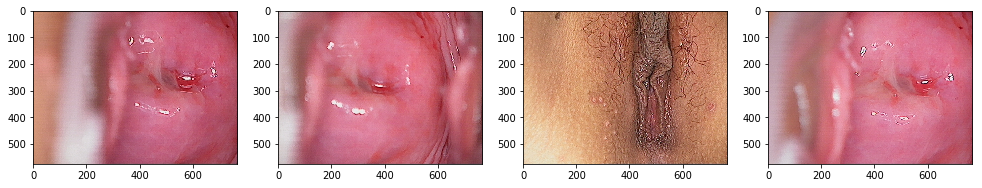

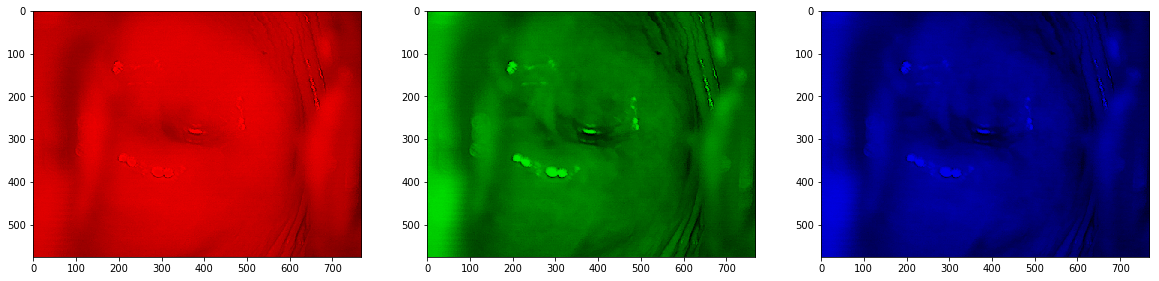

In [3]:
def cvt(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
def get_img_from_path(num_pat,num_pic):
    return cv2.imread(os.path.join(img_fosun_dir,str(num_pat),patient_dict[str(num_pat)][num_pic]))
def plot_img_from_path(num_pat,num_pic):
    plt.imshow(cvt(cv2.imread(os.path.join(img_fosun_dir,str(num_pat),patient_dict[str(num_pat)][num_pic]))))
def plot_imgs_from_path(num_pat):
    fig = plt.figure(figsize=(30,30))
    num_pic = len(patient_dict[str(num_pat)])
    if num_pic<3:
        for i in range(0,num_pic): 
            plt.subplot(100+10*num_pic+i+1)
            plt.imshow(cvt(cv2.imread(os.path.join(img_fosun_dir,str(num_pat),patient_dict[str(num_pat)][i]))))  
    else:
        for i in range(0,4): 
            plt.subplot(100+10*num_pic+i+1)
            plt.imshow(cvt(cv2.imread(os.path.join(img_fosun_dir,str(num_pat),patient_dict[str(num_pat)][i]))))
            
def plot_with_color(img,channel):
    size = img.shape
    zeros = np.zeros(size,dtype="uint8")
    if channel == 'r' or channel == 0:
        return cv2.merge([zeros,zeros,img])
    elif channel == 'g' or channel == 1:
        return cv2.merge([zeros,img,zeros])
    else:
        return cv2.merge([img,zeros,zeros])
    
def channel_split(image,opencv=True):
    if opencv == True:
        b_channel = image[:,:,0]
        g_channel = image[:,:,1]
        
        r_channel = image[:,:,2]
    else:
        r_channel = image[:,:,0]
        g_channel = image[:,:,1]
        b_channel = image[:,:,2]
    return r_channel,g_channel,b_channel

pat = 60
plot_imgs_from_path(pat)
img_1 = get_img_from_path(pat,1)
img_2 = get_img_from_path(pat,2)
img_3 = get_img_from_path(pat,3)
r_channel,g_channel,b_channel = channel_split(img_1)


plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(cvt(plot_with_color(r_channel,0)))
plt.subplot(132)
plt.imshow(cvt(plot_with_color(g_channel,1)))
plt.subplot(133)
plt.imshow(cvt(plot_with_color(b_channel,2)))

# Demo for remove spetral reflection

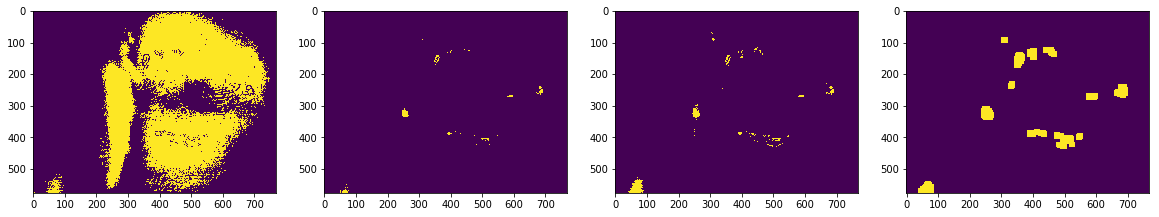

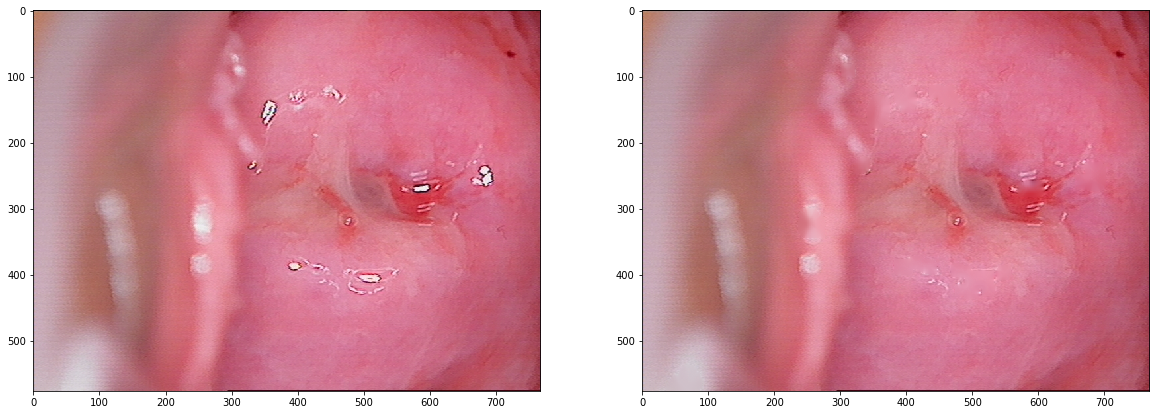

In [4]:

img = img_3
r_c = img[:,:,2]
g_c = img[:,:,1]
b_c = img[:,:,0]

plt.figure(figsize=(20,20))

_,r_thres = cv2.threshold(r_c, 210, 255, cv2.THRESH_BINARY)
_,g_thres = cv2.threshold(g_c, 208, 255, cv2.THRESH_BINARY)
_,b_thres = cv2.threshold(b_c, 206, 255, cv2.THRESH_BINARY)

plt.subplot(141)
plt.imshow(r_thres)
plt.subplot(142)
plt.imshow(g_thres)
plt.subplot(143)
plt.imshow(b_thres)
plt.subplot(144)

mixed = r_thres & b_thres & g_thres
kernel_dilate = np.ones((18, 18), np.uint8)
mask = cv2.dilate(mixed,kernel_dilate)
plt.imshow(mask)

dst = cv2.inpaint(img,mask,14,cv2.INPAINT_TELEA)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(cvt(img_3))
plt.subplot(122)
plt.imshow(cvt(dst))

(3264, 2448, 3) (4128, 3096, 3) (3264, 2448, 3)


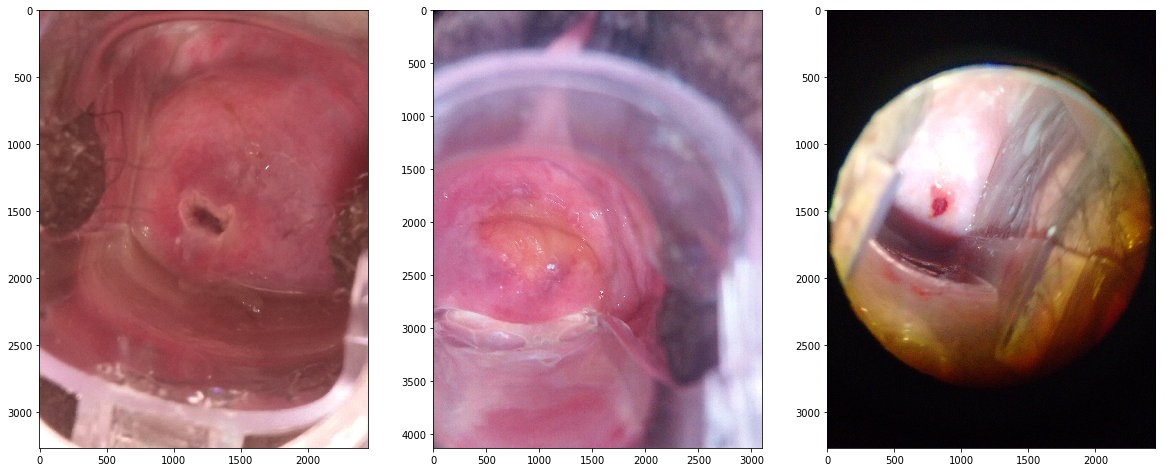

In [5]:
i1 = type_1_train[2]
i1 = cvt(cv2.imread(i1))
i2 = type_1_train[24]
i2 = cvt(cv2.imread(i2))
i3 = type_1_train[211]
i3 = cvt(cv2.imread(i3))

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(i1)
plt.subplot(132)
plt.imshow(i2)
plt.subplot(133)
plt.imshow(i3)

print(i1.shape,i2.shape,i3.shape)

In [6]:
def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type   
    """
    if image_type == "Type_1" or \
        image_type == "Type_2" or \
        image_type == "Type_3":
        data_path = os.path.join(TRAIN_DATA, image_type)
    elif image_type == "Test":
        data_path = TEST_DATA
    elif image_type == "AType_1" or \
          image_type == "AType_2" or \
          image_type == "AType_3":
        data_path = os.path.join(ADDITIONAL_DATA, image_type)
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    ext = 'jpg'
    return os.path.join(data_path, "{}.{}".format(image_id, ext))

def get_image_data(image_id, image_type):
    """
    Method to get image data as np.array specifying image id and type
    """
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [7]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else: 
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i-position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()    
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea
            

def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3]+1-maxArea[0]/abs(maxArea[1]-maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

def cropCircle(img):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)
            
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
            
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)
    
    rect = maxRect(ff)
    rectangle = [min(rect[0],rect[2]), max(rect[0],rect[2]), min(rect[1],rect[3]), max(rect[1],rect[3])]
    img_crop = img[rectangle[0]:rectangle[1], rectangle[2]:rectangle[3]]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)
    
    return [img_crop, rectangle, tile_size]

def Ra_space(img, Ra_ratio, a_threshold):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = np.zeros((w*h, 2))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w/2-i)*(w/2-i) + (h/2-j)*(h/2-j))
            Ra[i*h+j, 0] = R
            Ra[i*h+j, 1] = min(imgLab[i][j][1], a_threshold)
            
    Ra[:,0] /= max(Ra[:,0])
    Ra[:,0] *= Ra_ratio
    Ra[:,1] /= max(Ra[:,1])

    return Ra

def get_and_crop_image(image_id, image_type):
    img = get_image_data(image_id, image_type)
    initial_shape = img.shape
    [img, rectangle_cropCircle, tile_size] = cropCircle(img)
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = Ra_space(imgLab, 1.0, 150)
    a_channel = np.reshape(Ra[:,1], (w,h))
    
    g = mixture.GaussianMixture(n_components = 2, covariance_type = 'diag', random_state = 0, init_params = 'kmeans')
    image_array_sample = shuffle(Ra, random_state=0)[:1000]
    g.fit(image_array_sample)
    labels = g.predict(Ra)
    labels += 1 # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.
    
    # The cluster that has the highest a-mean is selected.
    labels_2D = np.reshape(labels, (w,h))
    gg_labels_regions = measure.regionprops(labels_2D, intensity_image = a_channel)
    gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
    cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

    mask = np.zeros((w * h,1),'uint8')
    mask[labels==cervix_cluster] = 255
    mask_2D = np.reshape(mask, (w,h))

    cc_labels = measure.label(mask_2D, background=0)
    regions = measure.regionprops(cc_labels)
    areas = [prop.area for prop in regions]

    regions_label = [prop.label for prop in regions]
    largestCC_label = regions_label[areas.index(max(areas))]
    mask_largestCC = np.zeros((w,h),'uint8')
    mask_largestCC[cc_labels==largestCC_label] = 255

    img_masked = img.copy()
    img_masked[mask_largestCC==0] = (0,0,0)
    img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY);
            
    _,thresh_mask = cv2.threshold(img_masked_gray,0,255,0)
            
    kernel = np.ones((11,11), np.uint8)
    thresh_mask = cv2.dilate(thresh_mask, kernel, iterations = 1)
    thresh_mask = cv2.erode(thresh_mask, kernel, iterations = 2)
    _, contours_mask, _ = cv2.findContours(thresh_mask.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours_mask, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(img, main_contour, -1, 255, 3)
    
    x,y,w,h = cv2.boundingRect(main_contour)
    
    rectangle = [x+rectangle_cropCircle[2],
                 y+rectangle_cropCircle[0],
                 w,
                 h,
                 initial_shape[0],
                 initial_shape[1],
                 tile_size[0],
                 tile_size[1]]

    return [image_id, img, rectangle]

In [8]:
def parallelize_image_cropping(image_ids):
    out = open('rectangles.csv', "w")
    out.write("image_id,type,x,y,w,h,img_shp_0_init,img_shape1_init,img_shp_0,img_shp_1\n")
    imf_d = {}
    p = Pool(cpu_count())
    for cur_type in enumerate(types):
        partial_get_and_crop = partial(get_and_crop_image, image_type = cur_type[1])    
        ret = p.map(partial_get_and_crop, image_ids[cur_type[0]])
        for i in range(len(ret)):
            out.write(image_ids[type[0]][i])
            out.write(',' + str(type[1]))
            out.write(',' + str(ret[i][2][0]))
            out.write(',' + str(ret[i][2][1]))
            out.write(',' + str(ret[i][2][2]))
            out.write(',' + str(ret[i][2][3]))
            out.write(',' + str(ret[i][2][4]))
            out.write(',' + str(ret[i][2][5]))
            out.write(',' + str(ret[i][2][6]))
            out.write(',' + str(ret[i][2][7]))
            out.write('\n')
            img = get_image_data(image_ids[type[0]][i], type[1])
            if(img.shape[0] > img.shape[1]):
                tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
            else:
                tile_size = (256, int(img.shape[0]*256/img.shape[1]))
            img = cv2.resize(img, dsize=tile_size)
            cv2.rectangle(img,
                          (ret[i][2][0], ret[i][2][1]), 
                          (ret[i][2][0]+ret[i][2][2], ret[i][2][1]+ret[i][2][3]),
                          255,
                          2)
            plt.imshow(img)
            plt.show()
        ret = []
    out.close()
    return


In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch import optim
from torch import Tensor
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset,Sampler
from torchvision import datasets,transforms
import torchvision.transforms as transforms
from torch.nn import functional as F
import math
import os
import sys
import warnings
import argparse
import numpy as np
import yaml
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm

sys.path.append("/home/shiyi/gpu/gpu/")
sys.path.append("/home/shiyi/colposcopy/colposcopy/util")
img_dir = "/data/colposcopy/colposcopy"

from gpu_allocation import set_gpu
corrupt_set  = set()
types = [1,2,3]
error = glob(os.path.join(img_dir,"train*","*","2845.jpg"))+ \
    glob(os.path.join(img_dir,"train*","*","5893.jpg"))+glob(os.path.join(img_dir,"train*","*","5892.jpg"))
print(error)

type_1_train = [i for i in glob(os.path.join(img_dir,"train*","Type_1","*.jpg")) if i not in error]
type_2_train = [i for i in glob(os.path.join(img_dir,"train*","Type_2","*.jpg")) if i not in error]
type_3_train = [i for i in glob(os.path.join(img_dir,"train*","Type_3","*.jpg")) if i not in error]

type_data_train = [type_1_train,type_2_train,type_3_train]

img_test   = glob(os.path.join(img_dir,"test","*.jpg"))
img_test_wo_answer = glob(os.path.join(img_dir,"test_stg2","*.jpg"))
test_path = os.path.join(img_dir,"solution_stg1_release.csv")

def get_dict(file_path,imgs):
    cur_dict = {}
    f = open(file_path)
    cont = f.readlines()[1:]
    for i in range(len(cont)):
        line = cont[i].rstrip('\n')
        cur_dict[i] = line.split(',').index('1')
    f.close()
    return cur_dict 

def collate_fn1(batch):
    x = [item[0] for item in batch if item[0] is not None]
    y = [item[1] for item in batch if item[0] is not None]
    return x,y

def cvt(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class ColpoTestDataset(Dataset):
    
    def __init__(self):
        self.type_dict = get_dict(test_path,img_test)
    def __getitem__(self, index):
        file_name = img_test[index]
        x = cv2.imread(file_name)
        if x is None:
            return  None,None
        #x = preprocess(x)
        x = cv2.resize(x,(224,224),interpolation=cv2.INTER_CUBIC)
        #x = cvt(x)
        y =[0,0,0]
        y [self.type_dict[index]-1] = 1
        return x,y
    def __len__(self):
        return len(self.type_dict)
    
class ColpoTrainDataset(Dataset):
    def __init__(self):
        self.Xy = []
        for type_index in types:
            for img_index in type_data_train[type_index-1]:
                self.Xy.append((img_index,type_index))
        self.x_data, self.y_data = zip(*self.Xy)
        self.x_data = list(self.x_data)
        self.y_data = list(self.y_data)
    def __getitem__(self, index):
        file_name = self.x_data[index]
        x = cv2.imread(file_name)
        if x is None:
            return None,None
        #x = preprocess(x)
        x = cv2.resize(x,(224,224),interpolation=cv2.INTER_CUBIC)
        #x = cvt(x)
        y = [0,0,0]
        y[self.y_data[index]-1] = 1
        return x,y
    def __len__(self):
        return len(self.x_data)

[u'/data/colposcopy/colposcopy/train_stg2/Type_2/2845.jpg', u'/data/colposcopy/colposcopy/train_stg2/Type_1/5893.jpg', u'/data/colposcopy/colposcopy/train_stg2/Type_2/5892.jpg']


In [10]:
class ResidualBlock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1,shortcut=None):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self,num_classes=3):
        super(ResNet,self).__init__()
        self.pre=nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2,1)
        )
        
        self.layer1=self._make_layer(64,64,3)
        self.layer2=self._make_layer(64,128,4,stride=2)
        self.layer3=self._make_layer(128,256,6,stride=2)
        self.layer4=self._make_layer(256,512,3,stride=2)
        self.fc=nn.Linear(512, num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        shortcut=nn.Sequential(
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel))
 
        layers=[ ]
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x=self.pre(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=F.avg_pool2d(x,7)
        x=x.view(x.size(0),-1)
        return self.fc(x)

In [11]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=3, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg11(**kwargs):
    model = VGG(make_layers(cfg['A']), **kwargs)
    return model


def vgg11_bn(**kwargs):
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    return model


def vgg13(**kwargs):
    model = VGG(make_layers(cfg['B']), **kwargs)
    return model


def vgg13_bn(**kwargs):
    model = VGG(make_layers(cfg['B'], batch_norm=True), **kwargs)
    return model


def vgg16(**kwargs):
    model = VGG(make_layers(cfg['D']), **kwargs)
    return model


def vgg16_bn(**kwargs):
    model = VGG(make_layers(cfg['D'], batch_norm=True), **kwargs)
    return model


def vgg19(**kwargs):
    model = VGG(make_layers(cfg['E']), **kwargs)
    return model


def vgg19_bn(**kwargs):
    model = VGG(make_layers(cfg['E'], batch_norm=True), **kwargs)
    return model



In [12]:
cuda = 1
md_index = 0
model = ["vgg19","vgg16","resnet"][md_index]
if cuda:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
    num_gpu = 1
    set_gpu(num_gpu)

if torch.cuda.is_available() and cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
batch_size_train = 16
batch_size_test = 16
colpoTrainDataset = ColpoTrainDataset()
colpoTestDataset = ColpoTestDataset()

train_loader = DataLoader(dataset=colpoTrainDataset,batch_size=batch_size_train,shuffle=True,num_workers = 2,collate_fn = collate_fn1)
test_loader = DataLoader(dataset =colpoTestDataset,batch_size=batch_size_test,shuffle=True,num_workers = 2,collate_fn = collate_fn1)

if model == "vgg19":
    net = vgg19_bn()
elif model == "vgg16":
    net = vgg16_bn()
elif model == "resnet":
    net = ResNet()

if cuda:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    net = net.cuda()
    
criterion = nn.MultiLabelSoftMarginLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.000008, momentum=0.8, weight_decay=5e-4)

for epoch in range(4):
    train_loss = 0.
    train_acc = 0
    index = 0
    total = 0
    for batch_x,batch_y in tqdm(train_loader):
        #print(batch_x,batch_y)
        #print(torch.full((224,224,3), 0))
        batch_x = Tensor(batch_x).permute([0,3,1,2])
        batch_y = Tensor(batch_y)
        total += batch_x.size()[0]
        out = net(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
        
        train_loss += loss.item()
        #print("out",out)
        pred = torch.max(out,1)[1]
        batch_y = torch.topk(batch_y, 1)[1].squeeze(1)
        #print("pred",pred,"batch_y",batch_y)
        train_correct = (pred == batch_y).sum().item()
        
        #print(train_correct,"correct of this batch of ", batch_x.size()[0])
        train_acc += train_correct
    torch.save(net, 'model.pth')    
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss /total, train_acc/ total))

    net.eval()
    eval_loss = 0.
    eval_acc = 0.
    total = 0
    for batch_x,batch_y in tqdm(test_loader):
        batch_x = Tensor(batch_x).permute([0,3,1,2])
        batch_y = Tensor(batch_y)
        total += batch_x.size()[0]
        #batch_x, batch_y = Variable(batch_x, volatile=True), Variable(batch_y, volatile=True)    
        out = net(batch_x)
        loss = criterion(out, batch_y)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        batch_y = torch.topk(batch_y, 1)[1].squeeze(1)
        num_correct = (pred == batch_y).sum().item()
        eval_acc += num_correct
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / total, eval_acc / total))
print(corrupt_set)    
    

('Found 4 GPU(s)', 'only 1 gpu below threshold')
Using GPU 1


100%|██████████| 514/514 [13:59<00:00,  1.52s/it]
/root/anaconda2/lib/python2.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.048080, Acc: 0.267414


  0%|          | 0/514 [00:00<?, ?it/s]

Test Loss: 0.044549, Acc: 0.292969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.044893, Acc: 0.259864


  0%|          | 0/514 [00:00<?, ?it/s]

Test Loss: 0.044549, Acc: 0.292969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.044881, Acc: 0.259864


  0%|          | 0/514 [00:00<?, ?it/s]

Test Loss: 0.044549, Acc: 0.292969


  0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.044886, Acc: 0.259864


100%|██████████| 32/32 [00:53<00:00,  1.58s/it]

Test Loss: 0.044549, Acc: 0.292969
set([])


In [ ]:
import random
!rm /home/shiyi/colposcopy/colposcopy/odoo/submission.csv
def test_net(save_file_path, img_dirs, net=None, transform=None, im_size=224, thresh=0.05):
    if net is None:
        net = torch.load('model.pth')
        test_all = img_test_wo_answer + img_test
    with open(save_file_path,'w') as f:
        f.write("image_name,Type_1,Type_2,Type_3")
        for idir in tqdm(test_all):
            name = idir.split('/')[-1]
            img = cv2.imread(idir)
            if img is None:
                label_ind = random.randint(0,3)
                label_oh = [name,'0.0','0.0','0.0']
                label_oh[label_ind] ='1.0'
                
            else:
                if transform != None:
                    img = transform(img)
                img = cvt(cv2.resize(img,(im_size,im_size),interpolation=cv2.INTER_CUBIC))
                x  = Tensor(img).permute([2,0,1]).unsqueeze(0)    
                out = net(x)[0]
                p = torch.nn.functional.softmax(out, dim=0)
                # to calculate loss using probabilities you can do below 
                #print(p)
                label_oh = [name]+map(lambda x: str(x.item()),p)
            
            label_oh ="\n"+ ','.join(label_oh)
            #print (label_oh)
            f.write(label_oh)

test_net("/home/shiyi/colposcopy/colposcopy/odoo/submission.csv", img_dir)       

 90%|████████▉ | 3616/4018 [07:46<01:35,  4.22it/s]

In [ ]:
!cd /home/shiyi/colposcopy/colposcopy/odoo
!ls
!wc -l /home/shiyi/colposcopy/colposcopy/odoo/submission.csv

!git add .
!git commit -m "tiredzzz"
!git push | echo WordBearerYI | echo sy941021

In [2]:
!kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f /home/shiyi/colposcopy/colposcopy/odoo/submission.csv -m "Message"

  0%|                                                | 0.00/213k [00:00<?, ?B/s]2019-07-05 15:35:32,830 WARNING Retrying (Retry(total=9, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')",),)': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AEnB2Up4jMp1ouHdhVoqHWmsDFxpBlTsV_4sST4g8AhL4RnJYNwquVf_F5m5iH5FcRDo_HArzJg2apAeB11AnhYMzOxwbDGcvLfy_f6c3HpkEVE2d-QGUEA
2019-07-05 15:35:33,893 WARNING Retrying (Retry(total=8, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLError("bad handshake: SysCallError(-1, 'Unexpected EOF')",),)': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AEnB2Up4jMp1ouHdhVoqHWmsDFxpBlTsV_4sST4g8AhL4RnJYNwquVf_F5m5iH5FcRDo_HArzJg2apAeB11AnhYMzOxwbDGcvLfy_f6c3HpkEVE2d-QGUEA
2019-07-05 15:35:35,962 WARNING Retrying (Retry(total=7, connect=None, read=No